In [1]:
% load_ext autoreload
% autoreload 2

import os

path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})

/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [2]:
from helper.synthesis import generate_pointwise_data

In [3]:
generate_pointwise_data()

100%|██████████| 60000/60000 [00:00<00:00, 227477.80it/s]


Data successfully generated!


<AxesSubplot: ylabel='Density'>

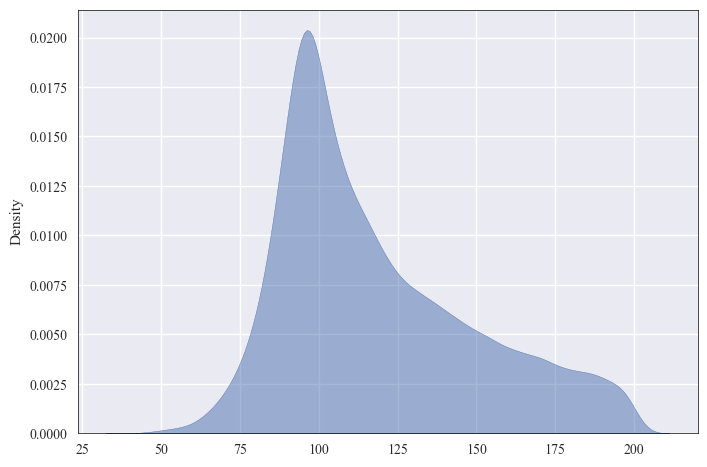

In [13]:
import seaborn as sns

from analysis.pointwise.model import load_data

params_range_train, params_range_test, price_train, price_test = load_data()

sns.kdeplot(price_train, fill = True, alpha = 0.5)

<AxesSubplot: ylabel='Density'>

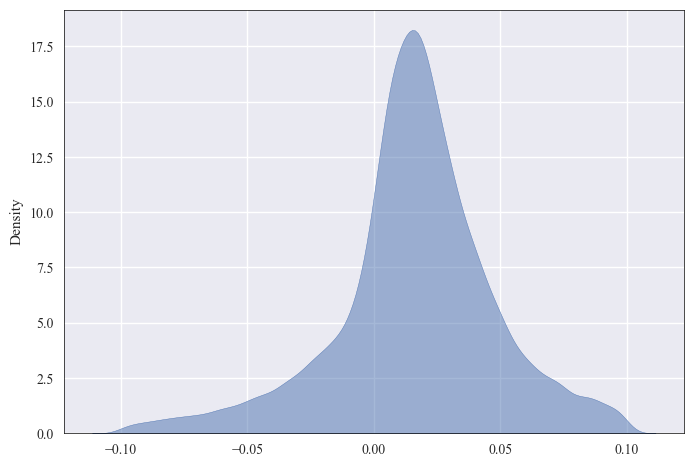

In [14]:
sns.kdeplot(params_range_train[:, 5], fill = True, alpha = 0.5)

In [15]:
import scipy

scipy.stats.describe(params_range_train[:, 5])

DescribeResult(nobs=41054, minmax=(-0.09997460298919944, 0.0999792785100099), mean=0.01598449554035423, variance=0.0010345298361706867, skewness=-0.4488075627220354, kurtosis=1.2321896035671873)

In [16]:
price_test.shape

(8409,)

In [17]:
params_range_test.shape

(8409, 6)

## Calibration

In [1]:
%load_ext autoreload
%autoreload 2

import os

path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})


import tensorflow as tf
from analysis.pointwise.utils import init_model, load_data, load_weights

/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [2]:
model = init_model()
load_weights(model)
params_range_train, params_range_test, price_train, price_test = load_data()

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  224       
                                                                 
 dense_1 (Dense)             multiple                  1056      
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             multiple                  1056      
                                                                 
 dense_3 (Dense)             multiple                  33        
                                                                 
Total params: 2,497
Trainable params: 2,433
Non-trainable params: 64
____________________________________________________

In [85]:
from scipy.optimize import Bounds

variable_bounds = {
        'a'    : [0.01, 0.20],
        'b'    : [1, 10],
        'sigma': [0.1, 1],
        'r'    : [0.00, 0.1]
        }

bounds = Bounds(
        [variable_bounds[key][0] for key in variable_bounds], [variable_bounds[key][1] for key in variable_bounds]
        )

from sklearn.metrics import mean_squared_error as mse

def objective_function(variable_input, fixed_input, model, y_true):

    y_pred = model(np.reshape(
            np.concatenate([fixed_input, variable_input])
            , newshape = (1, -1)))[0].numpy()

    return mse(y_true, y_pred)

import numpy as np
# objective_function([0.1, 5, 0.5, 0.05], [1, 0.04], model, np.array([100]))

In [88]:
import scipy

variable_input = params_range_test[0, 2:]
fixed_input = params_range_test[0, :2]
y_true = np.array([price_test[0]])
args = (fixed_input, model, y_true)
x0 = variable_input
s = scipy.optimize.minimize(
    objective_function, x0, method = 'trust-constr',
    options = {'verbose': 0}, bounds = bounds, args = args
    )

updated_variable_input = s.x

/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the ap

In [105]:
updated_variable_input = np.empty(shape = (1, 4))
for i in range(2):
    variable_input = params_range_test[i, 2:]
    fixed_input = params_range_test[i, :2]
    y_true = np.array([price_test[i]])
    args = (fixed_input, model, y_true)
    x0 = variable_input
    s = scipy.optimize.minimize(
        objective_function, x0, method = 'trust-constr',
        options = {'verbose': 0}, bounds = bounds, args = args
        )

    updated_variable_input = np.append(updated_variable_input, s.x.reshape((1, -1)), axis=0)

/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/Users/samaypanwar/.local/share/virtualenvs/FYP-Code-CTZTREBR/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the ap

In [115]:
import warnings


warnings.filterwarnings("ignore")

In [116]:
from analysis.pointwise.model_calibration import calibrate_synthetic

In [ ]:
calibrate_synthetic(model, calibration_size = 1000)

2023-02-20 19:34:04,854 | INFO: | model_calibration.py | calibrate_synthetic | 74: Beginning calibration for model dense with vasicek


 97%|█████████▋| 974/1000 [30:21<02:07,  4.92s/it]

0.02909752216412821

In [125]:
s

           message: `xtol` termination condition is satisfied.
           success: True
            status: 2
               fun: 5.169911140249588e-16
                 x: [ 7.416e-02  6.394e+00  7.142e-01  7.068e-03]
               nit: 99
              nfev: 675
              njev: 135
              nhev: 0
          cg_niter: 168
      cg_stop_cond: 2
              grad: [ 4.338e-04  1.218e-07  6.895e-07 -1.041e-08]
   lagrangian_grad: [ 1.412e-06  1.098e-07  4.362e-08 -1.381e-11]
            constr: [array([ 7.416e-02,  6.394e+00,  7.142e-01,  7.068e-03])]
               jac: [<4x4 sparse matrix of type '<class 'numpy.float64'>'
                    	with 4 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([-4.324e-04, -1.203e-08, -6.459e-07,  1.039e-08])]
            method: tr_interior_point
        optimality: 1.4124208664510708e-06
  constr_violation: 0.0
    execution_time: 0.4845

In [123]:
s.execution_time

0.4845249652862549